In [75]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import re
import contractions
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import time

In [76]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')

In [77]:
books_df = pd.read_excel("preprocessed_books_df.xlsx")

In [78]:
descriptions = books_df.description

The function below will help us to get insightful look at the structure of our language corpus.

In [5]:
def plot_top_ngrams(texts, ngram=1, top_n=15, stop_words='english', plot=False):
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram), stop_words=stop_words)
    X = vectorizer.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()

    freq_df = pd.DataFrame({'ngram': vocab, 'count': counts})
    freq_df = freq_df.sort_values(by='count', ascending=False).head(top_n)

    if plot:
        plt.figure(figsize=(10, 6))
        plt.barh(freq_df['ngram'][::-1], freq_df['count'][::-1])
        plt.xlabel('Frequency')
        plt.ylabel(f'{ngram}-gram')
        plt.title(f'Top {top_n} {ngram}-grams')
        plt.tight_layout()
        plt.show()

    return freq_df


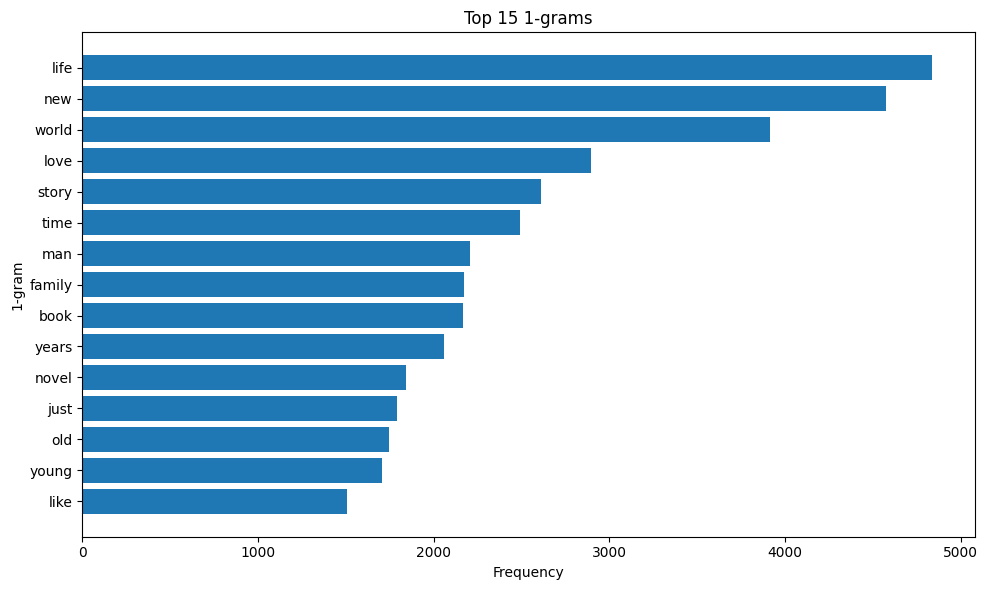

,ngram,count
25581,life,4837
29917,new,4572
48321,world,3913
26168,love,2893
41728,story,2612
44001,time,2493
26864,man,2209
16031,family,2172
5777,book,2164
48619,years,2057


In [6]:
plot_top_ngrams(descriptions, ngram=1, top_n = 15, plot=True)

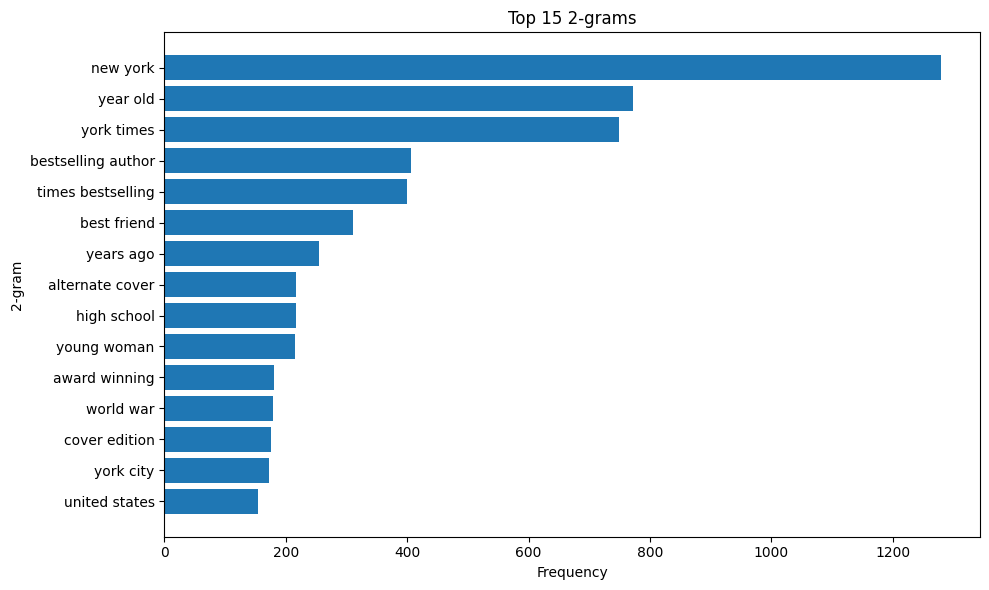

,ngram,count
341002,new york,1280
551494,year old,772
553325,york times,749
45216,bestselling author,407
496220,times bestselling,399
44590,best friend,310
551769,years ago,255
16634,alternate cover,217
228538,high school,217
554055,young woman,216


In [7]:
plot_top_ngrams(descriptions, ngram=2, top_n = 15, plot=True)

We observe that among most common bigrams we find some that are strictly related to the advertisment of the book rathter than the plot.

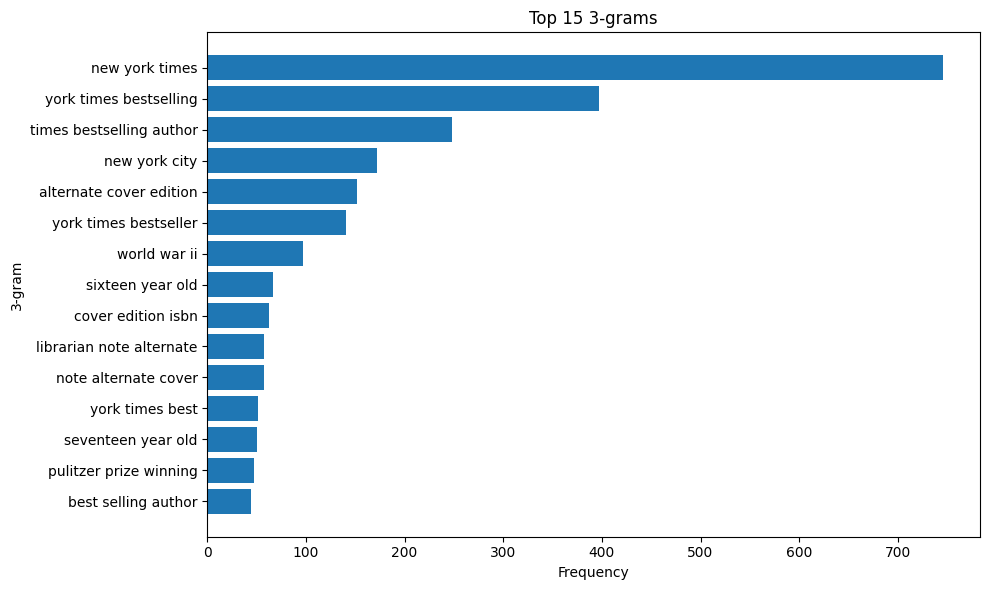

,ngram,count
406417,new york times,746
659104,york times bestselling,397
589295,times bestselling author,248
406212,new york city,172
18513,alternate cover edition,152
659081,york times bestseller,141
650932,world war ii,97
531133,sixteen year old,67
123277,cover edition isbn,63
334156,librarian note alternate,58


In [8]:
plot_top_ngrams(descriptions, ngram=3, top_n = 15, plot=True)

The plot of trigrams proves even more clearly, that there is a lot of noise in the descriptions, such as marketing slogans. This type of noise can lead to poor quality description embeddings. We will have to handle this. 

Now, let's take a look at the least common words.

In [9]:
def rare_ngrams(texts, ngram=1, max_count=1, stop_words='english'):
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram), stop_words=stop_words)
    X = vectorizer.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()

    freq_df = pd.DataFrame({'ngram': vocab, 'count': counts})

    # Filtr rzadkich n-gramów
    rare_df = freq_df[freq_df['count'] <= max_count].sort_values('count', ascending=True)
    
    return rare_df

In [10]:
rare_ngrams(descriptions)

,ngram,count
0,00,1
2,0001,1
3,000th,1
4,001,1
5,0060850523,1
...,...,...
49219,頭上有個彈孔,1
49222,ﬂame,1
49223,ﬂavorful,1
49224,ﬂavors,1


So, we've got some numbers, number-like objects and even Asian characters. 

In [71]:
def corpus_basic_stats(texts):
    lengths = [len(text.split()) for text in texts if text]

    stats = {
        'avg_description_words_num': round(np.mean(lengths),2),
        'min_description_words_num': np.min(lengths),
        'max_description_words_num': np.max(lengths)
    }

    return pd.DataFrame([stats])

In [79]:
corpus_basic_stats(descriptions)

,avg_description_words_num,min_description_words_num,max_description_words_num
0,150.1,1,1068


The descriptions of books vary a lot. Let's take a look at the shortest ones.

In [13]:
def display_short_texts(df, text_col='description', title_col='title', max_words=1):
    short_df = df[df[text_col].apply(lambda x: len(str(x).split()) <= max_words)]

    return short_df[[title_col, text_col]].reset_index().copy()

Titles for which the length of destription is 0:

In [14]:
display_short_texts(books_df)

,index,title,description
0,3465,"D.Gray-man, Volume 01",AKUMAとは『機械』と『魂』と『悲劇』を材料に造まれる悲しき悪性兵器。そのAKUMAを製造...
1,6462,The Giraffe and the Pelly and Me,キリンとサルとペリカン。おかしな、へんてこりんな3人ぐみだよ!


Descriptions containing up to 10 words:

In [15]:
display_short_texts(books_df, max_words=10)

,index,title,description
0,1747,Kindle Paperwhite User's Guide,Kindle Paperwhite User's Guide
1,2985,"Nemesis (Harry Hole, #4)",（奈斯博作品集 2） (北歐犯罪小說) (Traditional Chinese Editi...
2,3465,"D.Gray-man, Volume 01",AKUMAとは『機械』と『魂』と『悲劇』を材料に造まれる悲しき悪性兵器。そのAKUMAを製造...
3,3473,The Dark Elf Trilogy Collector's Edition (Forg...,Three-book set: The Dark Elf Trilogy--Homeland...
4,4371,I Am Ozzy,I Am Ozzy
5,4712,American on Purpose: The Improbable Adventures...,American on Purpose: The Improbable Adventures...
6,5407,Figure Drawing for All It's Worth (How to draw...,Hardback book. 204 pages.
7,6462,The Giraffe and the Pelly and Me,キリンとサルとペリカン。おかしな、へんてこりんな3人ぐみだよ!
8,7425,The Egg,A short story about the universe.
9,7750,"Sleeping Beauty (Disney Princess, 5)",This book tells the tale of Disney's Sleeping ...


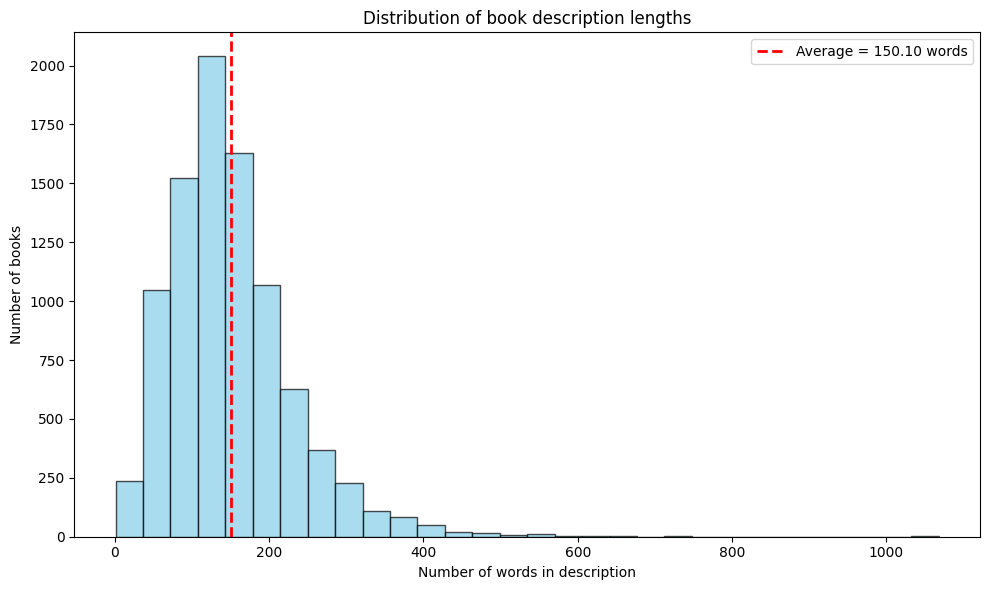

In [16]:
lengths = books_df['description'].apply(lambda x: len(x.split()))

avg_length = lengths.mean()

plt.figure(figsize=(10,6))
plt.hist(lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(avg_length, color='red', linestyle='dashed', linewidth=2, label=f'Average = {avg_length:.2f} words')
plt.xlabel('Number of words in description')
plt.ylabel('Number of books')
plt.title('Distribution of book description lengths')
plt.legend()
plt.tight_layout()
plt.show()

We decide to not proceed with the books that title is shorter than 30 characters.

In [17]:
books_df = books_df[books_df['description'].apply(lambda x: len(str(x).split()) >= 30)]
descriptions = books_df[['book_id', 'description']].reset_index().drop('index', axis = 1)

In [18]:
#display_short_texts(books_df, max_words=20)

In [19]:
descriptions

,book_id,description
0,1,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1,2,Harry Potter's life is miserable. His parents ...
2,3,About three things I was absolutely positive.\...
3,4,The unforgettable novel of a childhood in a sl...
4,5,Alternate Cover Edition ISBN: 0743273567 (ISBN...
...,...,...
8934,9981,"A high-school girl in Harlem, Geneva Settle, i..."
8935,9982,In Karen Marie Moning’s latest installment of ...
8936,9985,"In the year 2000, computers are the new superp..."
8937,9987,A CIA agent's two-year-old child was stolen in...


## Text preparation pipeline

So now that we've gathered information about the descriptions, we can proceed to preprocessing.

### Important information extraction

It is essential to find the best way to get the most out of descriptions in case of creating embeddings. The marketing inserts (and probably lots of more kinds of noise) were proven by the ngram analysis to play a huge part in the text, which is a bit worring, because it could potenially make our embeddings less informative. 

The first thing that comes to my mind is to use summarizations of preprocessed book descriptions - that could make embeddings semantically consistent and more plot-oriented. On the other hand we lose some of the details.<br>
The second potential approach is to use some kind of keywords-extraction or keyphrases-extraction technique, so that the embedding model would get the most important words/phrases as input.  


We will start with the first strategy - summarization. We will use a BART model that was trained on text-summary pairs dataset. 

In [20]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

Device set to use cpu


In [21]:
def summarize_book(description, max_length=70, min_length=20):
    result = summarizer(description, max_length=max_length, min_length=min_length, do_sample=False)
    return result[0]['summary_text']

An example of summarized description:

In [55]:
summarize_book(descriptions.description[0])

"Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love."

The original book bescription:

In [24]:
descriptions.description[0]

"WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love."

In [25]:
print(f'By applying the summarization function we have reduced the description by {len(descriptions.description[0]) - len(summary1)} characters.')

By applying the summarization function we have reduced the description by 540 characters.


In [38]:
summaries = []

for idx, desc in enumerate(tqdm(descriptions.description.to_list(), desc="Summarizing")):
    try:
        summary = summarize_book(desc)
        summaries.append(summary)
    except Exception as e:
        print(f"Błąd przy streszczaniu opisu nr {idx}: {e}")
        summaries.append(None) 

Summarizing:  37%|██████████████████████▋                                      | 3321/8939 [4:30:21<6:57:35,  4.46s/it]

Błąd przy streszczaniu opisu nr 3321: index out of range in self


Summarizing: 100%|██████████████████████████████████████████████████████████████| 8939/8939 [12:39:18<00:00,  5.10s/it]


In [41]:
descriptions["summaries"] = summaries

### Data cleaning

We perform following preprocessing steps:
- converting words to lowercase
- white spaces cleaning
- non-alpha characters removal (just in case)
- stop-words cleaning

In [48]:
def clean_text(input_text):    
    # clean_text = re.sub('<[^<]+?>', '', input_text)  
    # clean_text = re.sub(r'http\S+', '', clean_text)
    
    clean_text = input_text.lower()
    clean_text = re.sub('\s+', ' ', clean_text)
    clean_text = re.sub('[^a-zA-Z\s]', '', clean_text)
    
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)

    return clean_text

Turns out that the model didn't summarize one of the descriptions - let's drop it.

In [61]:
descriptions[descriptions.summaries.isna()]

,book_id,description,summaries
3321,3831,More About DaveA Man Named Dave is the conclus...,None


In [63]:
descriptions = descriptions.dropna()

In [64]:
descriptions["preprocessed_summarization"] = descriptions["summaries"].apply(clean_text)

C:\Users\gabri\AppData\Local\Temp\ipykernel_3808\1903643063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions["preprocessed_summarization"] = descriptions["summaries"].apply(clean_text)


Example of description after applying the preprocessing function:

In [67]:
descriptions.preprocessed_summarization[0]

'sixteenyearold katniss everdeen regards death sentence steps forward take sisters place games without really meaning becomes contender win start making choices weight survival humanity life love'

The summarized version:

In [68]:
descriptions.summaries[0]

"Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love."

New corpus stats:

In [70]:
corpus_basic_stats(descriptions.preprocessed_summarization)

,avg_description_words_num,min_description_words_num,max_description_words_num
0,22.14,5,40


In [74]:
descriptions.to_excel('summrized_preprocessed_descriptions.xlsx')